In [ ]:
# KerasCV는 tensorflow와 keras를 기반으로 Vision작업을 할 수 있는 toolkit 모음
# 쉽게 말하면 Classification(분류), Object Detection(객체 탐지), Segmentation(세분화)
# Generation(생성) 작업을 할 수 있는 최신 딥러닝 기술들을 손쉽게 구현할 수 있도록 도와주는 라이브러리 모음.

In [ ]:
# 당연히 이 KerasCV를 설치해야지 사용할 수 있어요!
# 현재 pip로 설치할 수 있는 KerasCV 버전은 0.9.0 이에요!
# 우리는 개발 버전을 가져다가 사용할거에요!

In [ ]:
# 이렇게 가상환경과 KerasCV까지 설정하고 설치했어요!
# Model 생성하고 학습하고 평가하는 작업은 상당히 편하고 쉬워요!
# 하지만 모델 학습에 사용되는 학습데이터와 평가데이터 만드는게 어려워요!
# TFRecord와 tf.data.Dataset을 이용해서 만들어야 해요!

In [ ]:
# KerasCV로 Object Detection을 하려면 어떤 형태로 tf.data.Dataset을 생성해야 하나요?

# 기본 구조 : 튜플이에요!
# (images, labels) => Dataset 1건이 이렇게 생겼어요!
# images : 이미지 정보를 담고 있는 Tensor. 이미지의 높이, 너비, 채널. 0~1 사이로 정규화
# labels : Dict로 되어 있어요! 기존처럼(분류처럼) 하나의 숫자로 되어있지 않아요!
# labels = {
    # 'boxes' : tf.Tensor,    => (batch_size, num_boxes, 4)
#     'classes' : tf.Tensor   => (batch_size, num_boxes)
# }

In [ ]:
# 우리가 가지고 있는 학습할 데이터를 PASCAL VOC Data 형태로 만들어요!
# VOCdevkit
#   ㄴ VOC2007
#        ㄴ JPEGImages
#        ㄴ Annotations
#        ㄴ ImageSets
#             ㄴ Main  train.txt  val.txt

In [1]:
# 결국 우리가 알아야 하는건...
# PASCAL VOC 형식 -> tf.data.Dataset으로 변환하는 방법

# 사용하는 폴더를 위한 변수를 설정
ROOT_FOLDER = '/root/jupyter_home/keras_Object_Detection'

In [2]:
!mkdir $ROOT_FOLDER

In [3]:
cd $ROOT_FOLDER

/root/jupyter_home/keras_Object_Detection


In [ ]:
# PASCAL VOC 2007버전이 있어야 그걸 가지고 Dataset을 만들수 있어요!
# 아마도 YOLO했을 때 YOLO_Object_Detection/VOC라는 폴더 안에 tar.gz 파일이 있어요.
# 이거 가지고 올거에요!
# 가져왔으면 압축을 풀어줘요!
!tar xvf VOCtrainval_06-Nov-2007.tar

In [6]:
# Pascal VOC Dataset을 TFRecord로 변환하는 코드
import os
import tensorflow as tf
import xml.etree.ElementTree as ET

# VOC 클래스 목록 (20 classes)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
class_name_to_id = {name: i for i, name in enumerate(VOC_CLASSES)}

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    bboxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        label = class_name_to_id[name]

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, width, height, bboxes, labels

def create_tf_example(image_path, xml_path):
    filename, width, height, bboxes, labels = parse_voc_xml(xml_path)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    xmins = [box[0] / width for box in bboxes]
    ymins = [box[1] / height for box in bboxes]
    xmaxs = [box[2] / width for box in bboxes]
    ymaxs = [box[3] / height for box in bboxes]

    classes_text = [VOC_CLASSES[label].encode('utf8') for label in labels]
    classes = labels

    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

def generate_tfrecord(voc_dir, split_txt, output_path):
    annotation_dir = os.path.join(voc_dir, 'Annotations')
    image_dir = os.path.join(voc_dir, 'JPEGImages')

    with tf.io.TFRecordWriter(output_path) as writer:
        with open(split_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        for img_id in lines:
            xml_path = os.path.join(annotation_dir, f"{img_id}.xml")
            img_path = os.path.join(image_dir, f"{img_id}.jpg")

            if os.path.exists(xml_path) and os.path.exists(img_path):
                example = create_tf_example(img_path, xml_path)
                writer.write(example.SerializeToString())

VOC_ROOT_DIR = '/root/jupyter_home/keras_Object_Detection'

# 실행
generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/train.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_train.tfrecord"
)

generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/val.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_val.tfrecord"
)

In [7]:
# 이렇게 TFRecord가 생성되었으면 이걸 이용해서 tf.data.Dataset을 생성하면 되요!
# 만들어진 TFRecord를 이용해서 tf.data.Dataset을 생성하는 코드
IMAGE_SIZE = 512

def parse_tfrecord(example):
    features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    xmins = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    ymins = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    xmaxs = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymaxs = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])

    boxes = tf.stack([xmins, ymins, xmaxs, ymaxs], axis=-1)

    return {
        "images": image,
        "bounding_boxes": {
            "boxes": boxes,
            "classes": tf.cast(labels, tf.int32),
        }
    }

def load_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # padded_batch 필수
    dataset = dataset.shuffle(1000).padded_batch(
        batch_size,
        padded_shapes={
            "images": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    ).prefetch(tf.data.AUTOTUNE)

    return dataset


train_ds = load_dataset("./voc2007_train.tfrecord", 
                        batch_size=8)

val_ds = load_dataset("./voc2007_val.tfrecord", 
                        batch_size=8)     

In [8]:
# 그래서 재학습에 필요한 Dataset을 준비했어요!
# 제공된 코드로 PASCAL VOC 형식으로 되어있는 이미지 데이터를
# TFRecord를 이용해서 Dataset으로 변환까지 시켜놨어요!

In [10]:
# Model 생성
from keras_cv.models import RetinaNet # EfficientDet도 있어요! (원래되다가 개발버전에서 빠졌어요!)

model = RetinaNet.from_preset(
    'retinanet_resnet50_pascalvoc',
    bounding_box_format='xyxy',
    num_classes=20
)

100%|████████████████████████████████████████████████████████████████████████| 136M/136M [00:57<00:00, 2.50MB/s]
/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [11]:
# Model compile
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              classification_loss='focal', # focal (default)
              box_loss='smoothl1') # smoothl1 (default)

In [ ]:
# 모델 재학습
model.fit(train_ds,
          epochs=10,
          verbose=1)
# Epoch 10/10
# 312/312 [==============================] - 131s 420ms/step - 
# loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - 
# percent_boxes_matched_with_anchor: 0.8076

1/1 [==============================] - 9s 9s/step


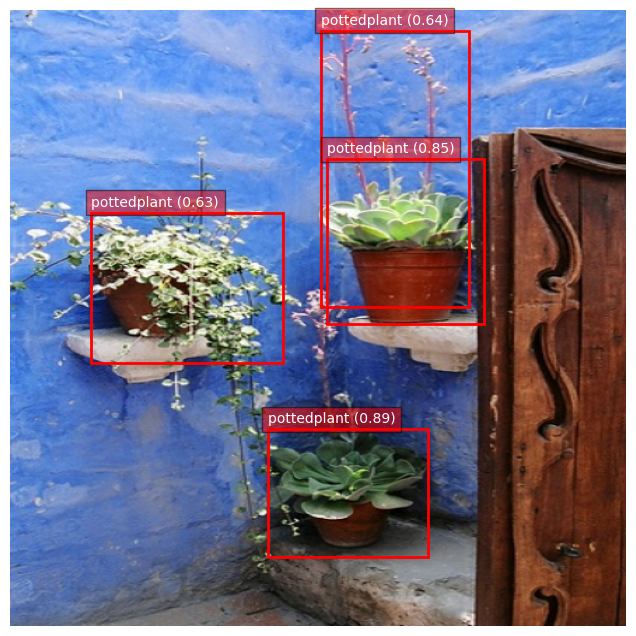

In [13]:
# 예측 및 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def visualize_prediction(image, boxes, classes, scores, threshold=0.3):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box, cls, score in zip(boxes, classes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = VOC_CLASSES[int(cls)]
        ax.text(
            x1, y1 - 5,
            f"{class_name} ({score:.2f})",
            fontsize=10,
            color="white",
            bbox=dict(facecolor="red", alpha=0.5)
        )

    plt.axis("off")
    plt.show()

# 예측 결과 (batched)
sample = next(iter(val_ds))
images, y_true = sample["images"], sample["bounding_boxes"]

# 예측 (batched)
y_pred = model.predict(images)

# 첫 번째 이미지만 시각화
image = images[0].numpy()
# 이미지 크기에 맞게 scale (RetinaNet은 512x512로 resize됨)
image = np.clip(image * 255, 0, 255).astype("uint8")

boxes = y_pred["boxes"][0]
classes = y_pred["classes"][0]
scores = y_pred["confidence"][0]

visualize_prediction(image, boxes, classes, scores, threshold=0.3)